In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!nvidia-smi

Mon Apr 19 08:12:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip install -q -U watermark

In [6]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,torchvision

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy      : 1.19.5
pandas     : 1.1.5
torch      : 1.8.1+cu101
torchvision: 0.9.1+cu101



In [7]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
train_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/70:30_train_test/*'))
len(train_folders)

5

In [9]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

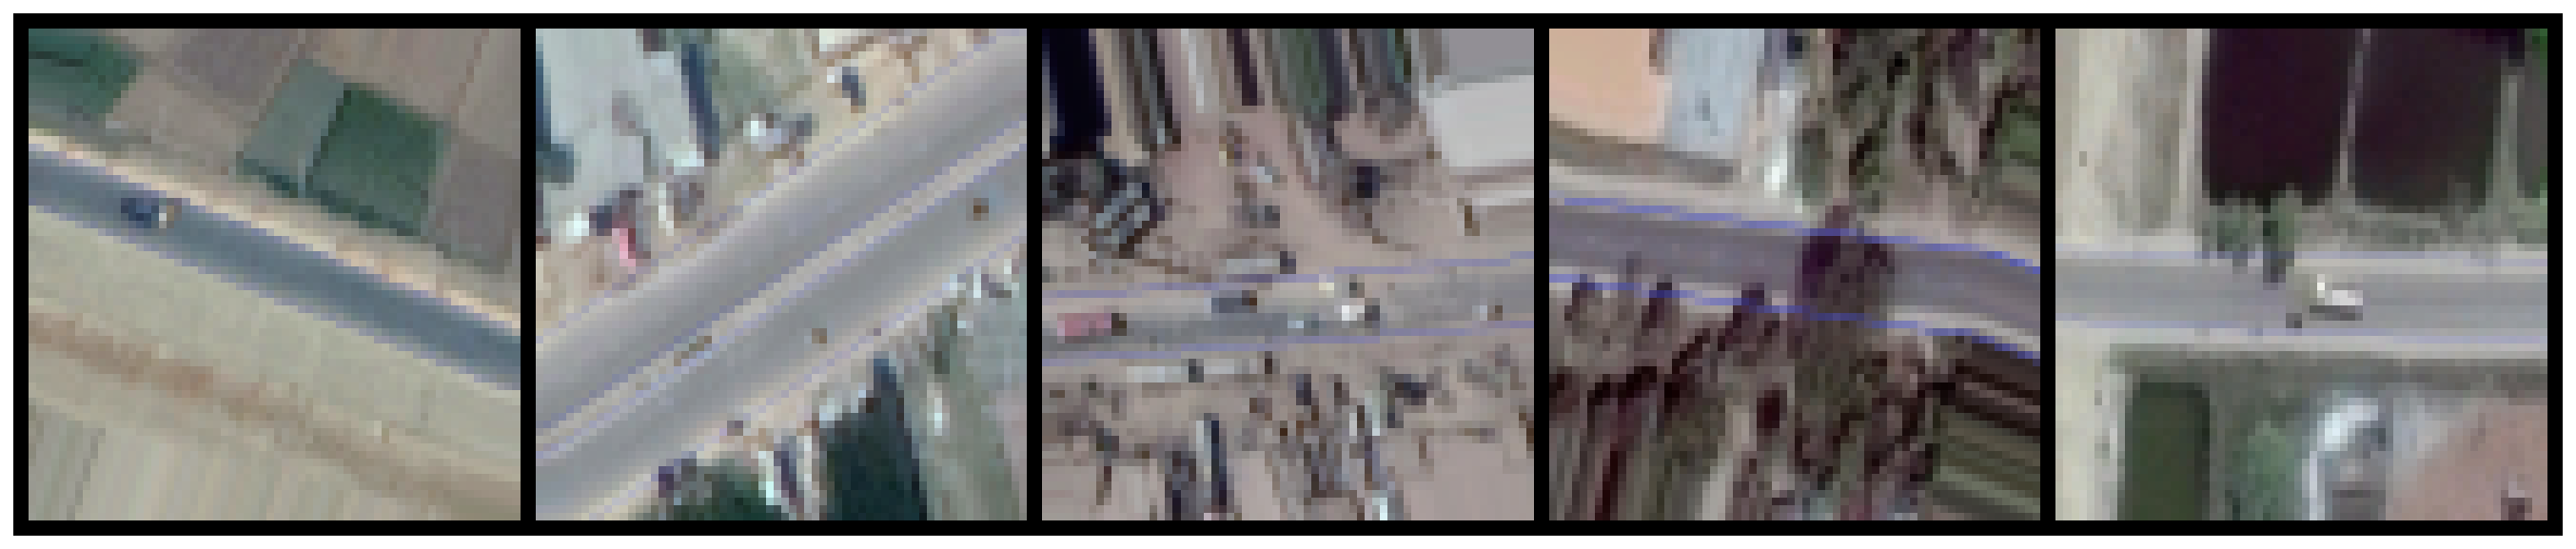

In [10]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in train_folders]
show_sign_grid(sample_images)

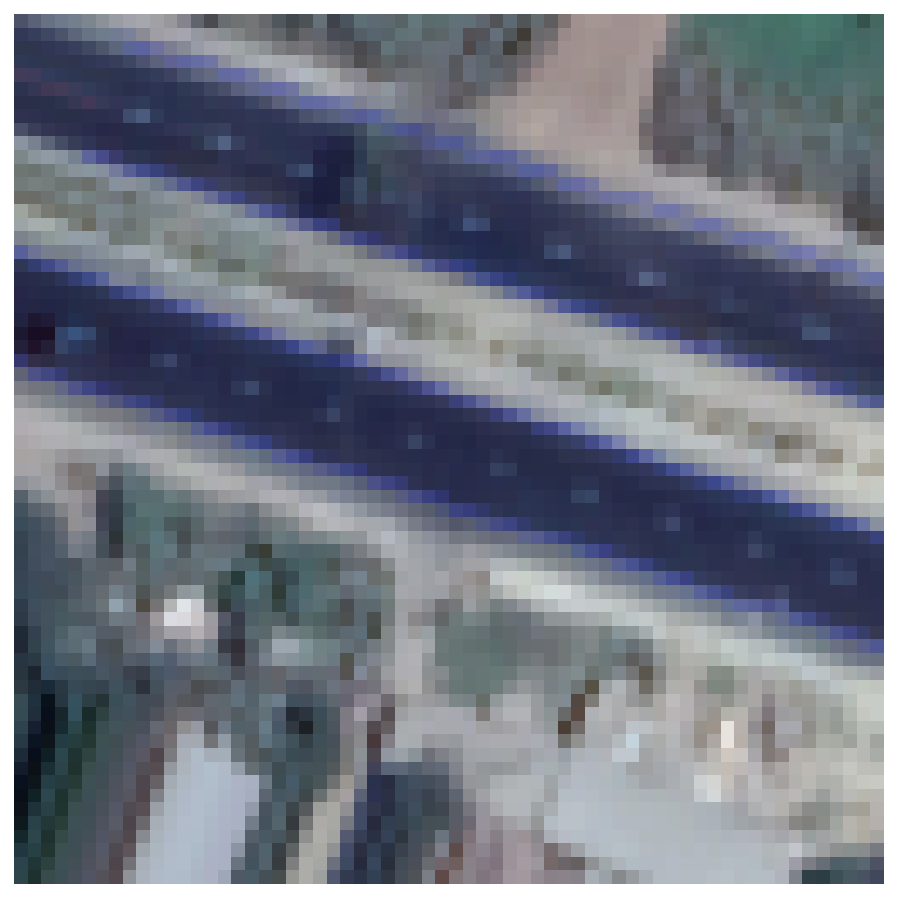

In [11]:
img_path = glob(f'{train_folders[2]}/*png')[20]

show_image(img_path)

In [12]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [13]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [12]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 4228
fair: 4779
good: 4812
poor: 4368
vbad: 3728


In [13]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [13]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.Resize(224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [18]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=16, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [19]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'train': 17530, 'val': 4385}

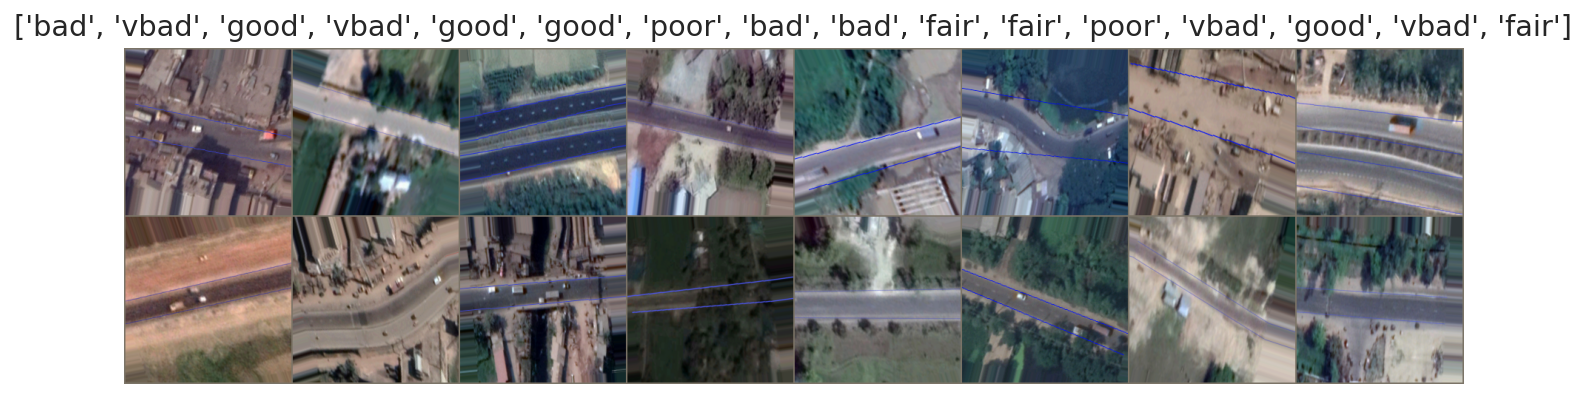

In [20]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def create_model():
  model = models.vgg11_bn(pretrained=True)
  return model.to(device)

In [22]:
base_model = create_model()

In [23]:
base_model.classifier[-1]

Linear(in_features=4096, out_features=1000, bias=True)

In [24]:
IN_FEATURES = base_model.classifier[-1].in_features 

final_fc = nn.Linear(IN_FEATURES,len(class_names) )

In [25]:
base_model.classifier[-1] = final_fc

In [26]:
print(base_model.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=5, bias=True)
)


In [27]:
base_model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [28]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [29]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [30]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [27]:
%%time
#64*64
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.9351202938025885 accuracy 0.6197375926982316
Val   loss 0.6415598260751669 accuracy 0.7470923603192702

Epoch 2/10
----------
Train loss 0.44855956270964475 accuracy 0.8269252709640617
Val   loss 0.5212977960489799 accuracy 0.8075256556442417

Epoch 3/10
----------
Train loss 0.21574732901555668 accuracy 0.9198516828294353
Val   loss 0.48781711539840733 accuracy 0.8312428734321551

Epoch 4/10
----------
Train loss 0.10962333661558474 accuracy 0.9618368511123788
Val   loss 0.4557828737165107 accuracy 0.853363740022805

Epoch 5/10
----------
Train loss 0.0705269416199358 accuracy 0.9767256132344553
Val   loss 0.4982424249359663 accuracy 0.849714937286203

Epoch 6/10
----------
Train loss 0.057819968258454736 accuracy 0.9795208214489447
Val   loss 0.4663982587913726 accuracy 0.8649942987457241

Epoch 7/10
----------
Train loss 0.03997032128664899 accuracy 0.9870507701083857
Val   loss 0.5172824881619908 accuracy 0.8643101482326112

Epoch 8/10
----------


In [31]:
%%time
#224*224
base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.676640678591428 accuracy 0.7290359383913292
Val   loss 0.5762173175667836 accuracy 0.7762827822120867

Epoch 2/10
----------
Train loss 0.3048280099666861 accuracy 0.8831717056474615
Val   loss 0.550335558605465 accuracy 0.8287343215507411

Epoch 3/10
----------
Train loss 0.1461089941618597 accuracy 0.9471762692527097
Val   loss 0.6218253601503304 accuracy 0.8376282782212087

Epoch 4/10
----------
Train loss 0.07896687448427105 accuracy 0.9721620079863093
Val   loss 0.2503093397626865 accuracy 0.9194982896237172

Epoch 5/10
----------
Train loss 0.047765343547677606 accuracy 0.9835710211066743
Val   loss 0.21968091049668145 accuracy 0.9304446978335233

Epoch 6/10
----------
Train loss 0.039660722476841936 accuracy 0.9860239589275528
Val   loss 0.2330371328371323 accuracy 0.9254275940706955

Epoch 7/10
----------
Train loss 0.02915980262301726 accuracy 0.9904734740444952
Val   loss 0.3665314316163263 accuracy 0.9030786773090079

Epoch 8/10
----------


In [32]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

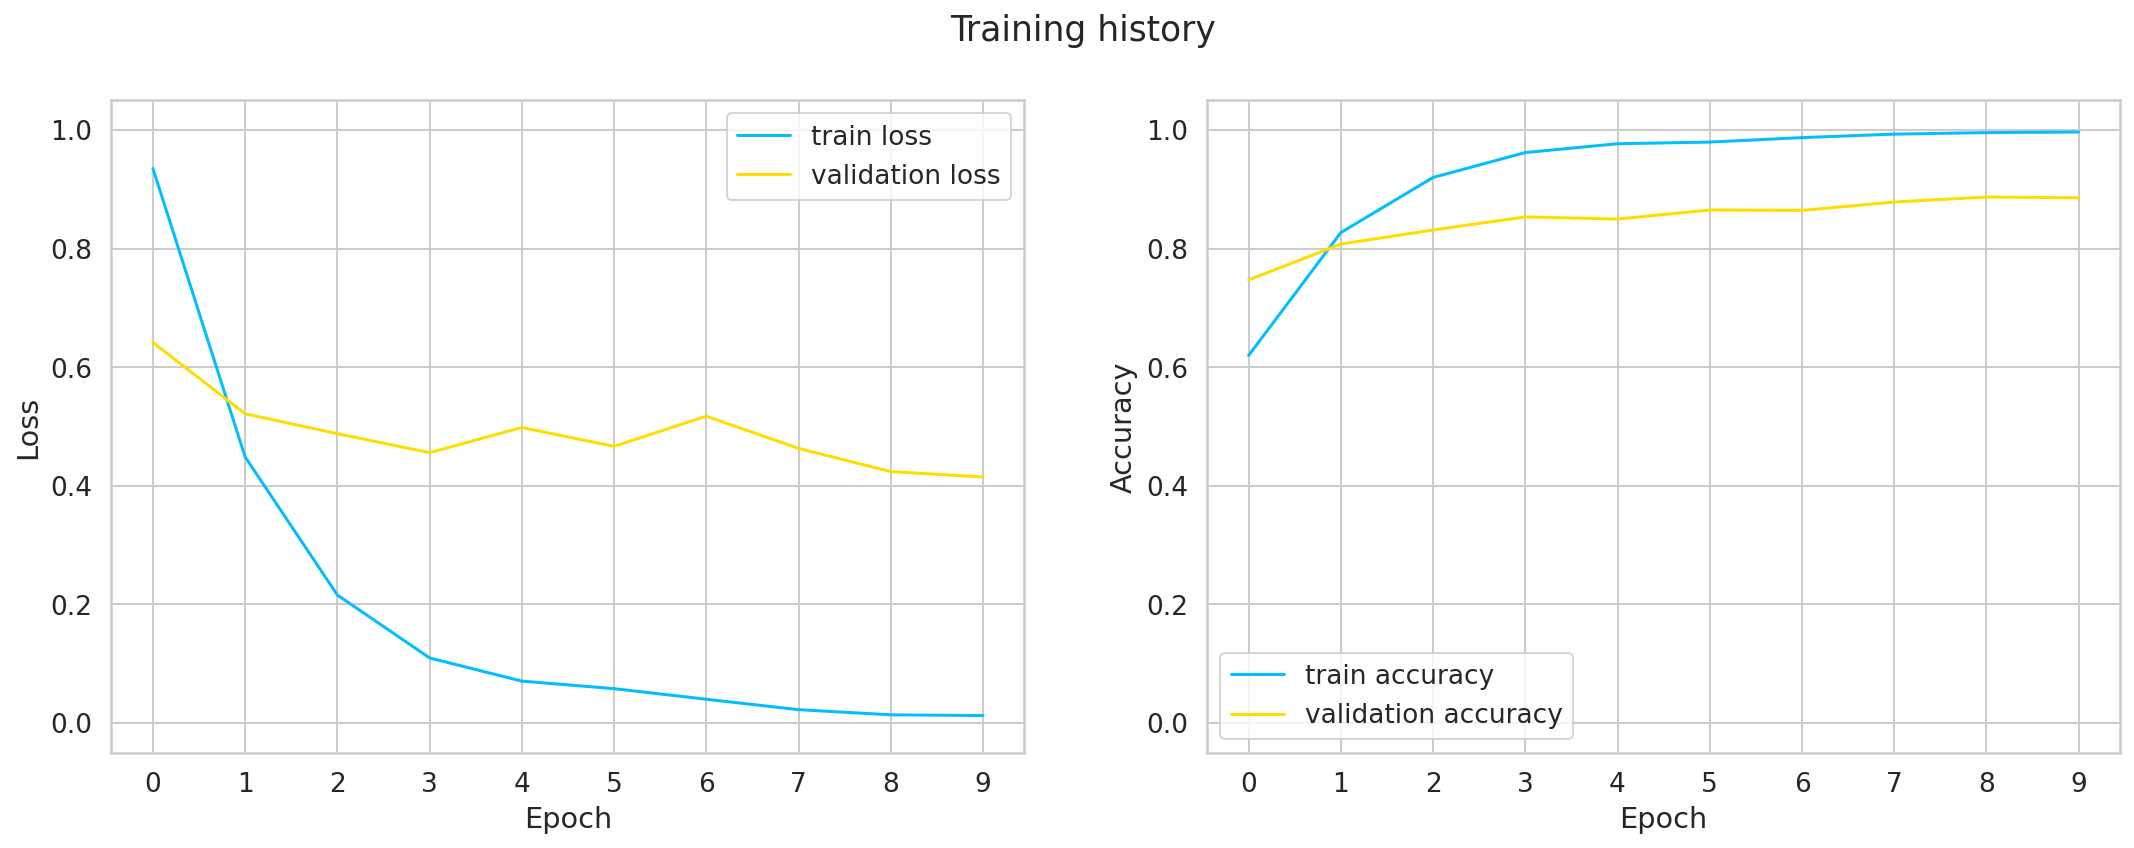

In [29]:
#64*64
plot_training_history(history)

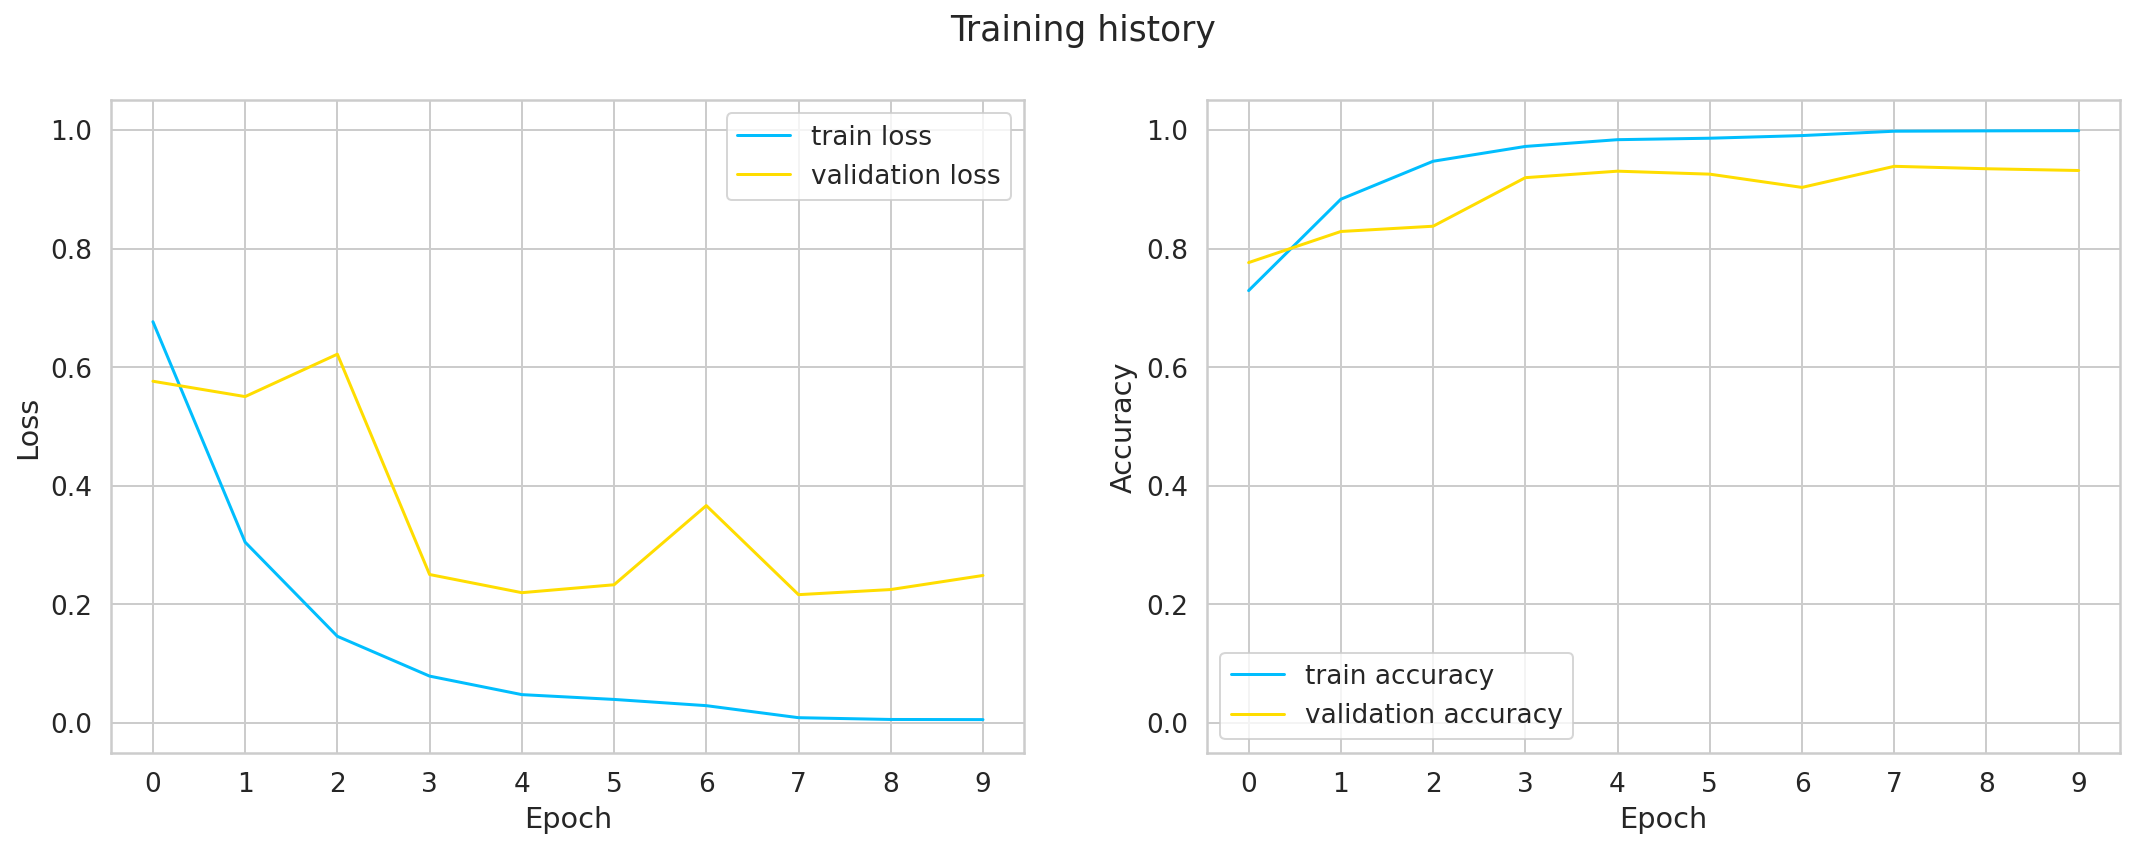

In [33]:
#224*224
plot_training_history(history)

# **Test Data**(unseen)

In [34]:
test_folders = sorted(glob('/content/drive/MyDrive/70:30_Datasets/test_set/*'))
len(test_folders)

5

In [35]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

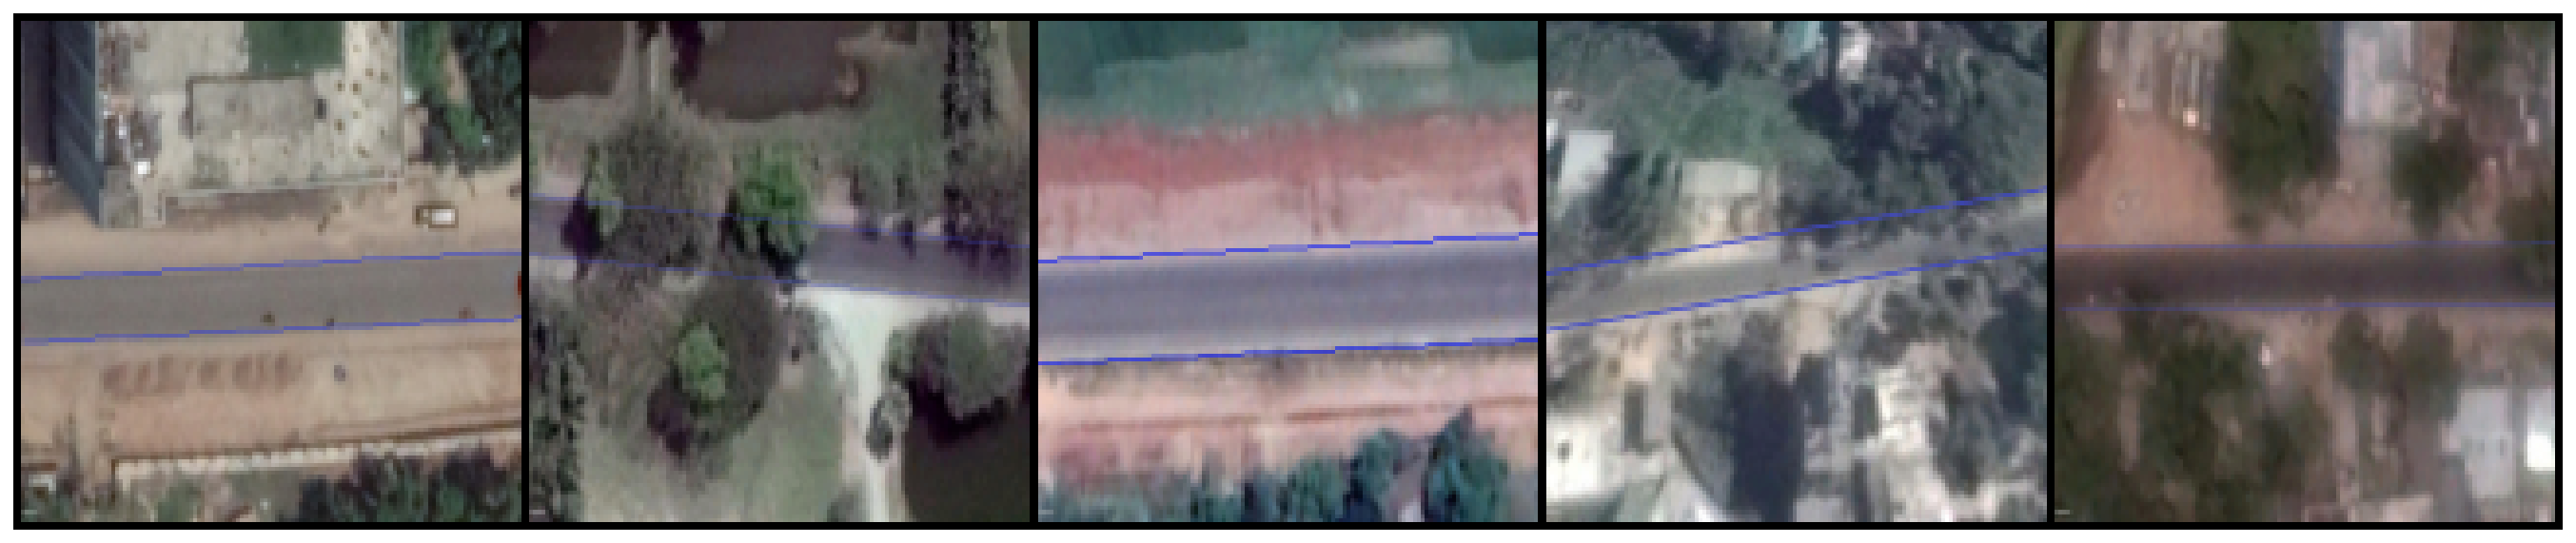

In [36]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in test_folders]
show_sign_grid(sample_images)

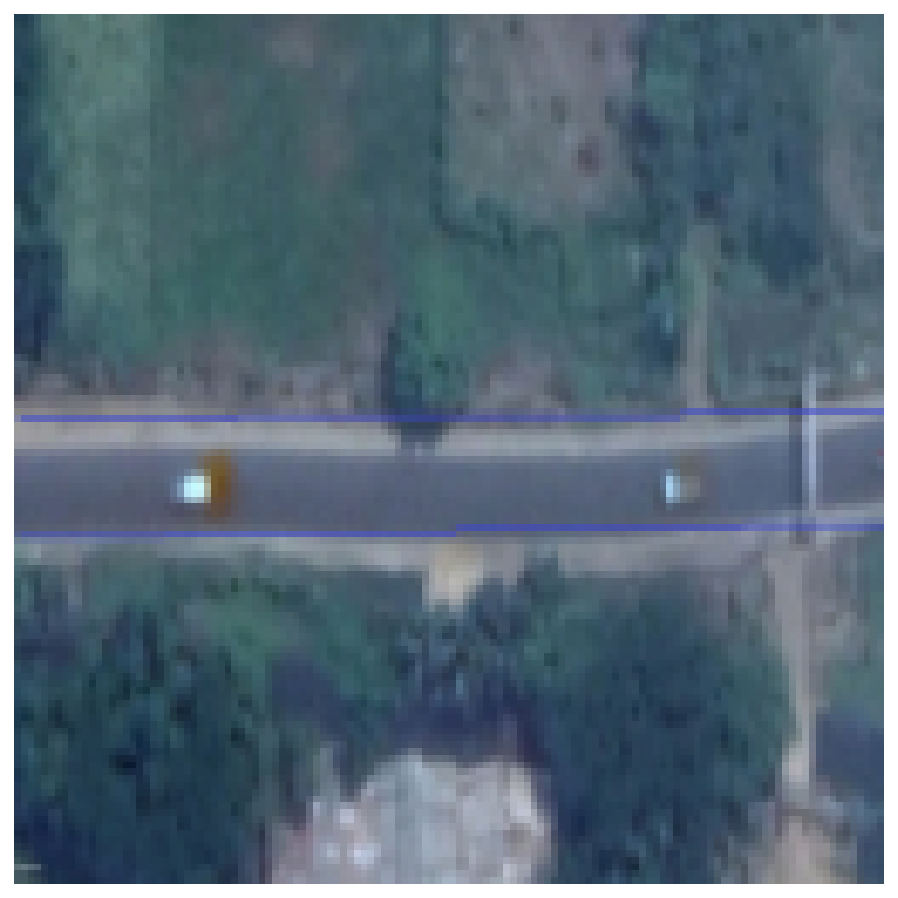

In [37]:
img_path = glob(f'{test_folders[4]}/*png')[1]

show_image(img_path)

In [39]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [40]:
!rm -rf data

DATA_DIR = Path('test_data')

DATASETS = ['test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [41]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{test_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 251
fair: 290
good: 295
poor: 263
vbad: 231


In [37]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [42]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [43]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=5, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [44]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['test'].classes

dataset_sizes

{'test': 1330}

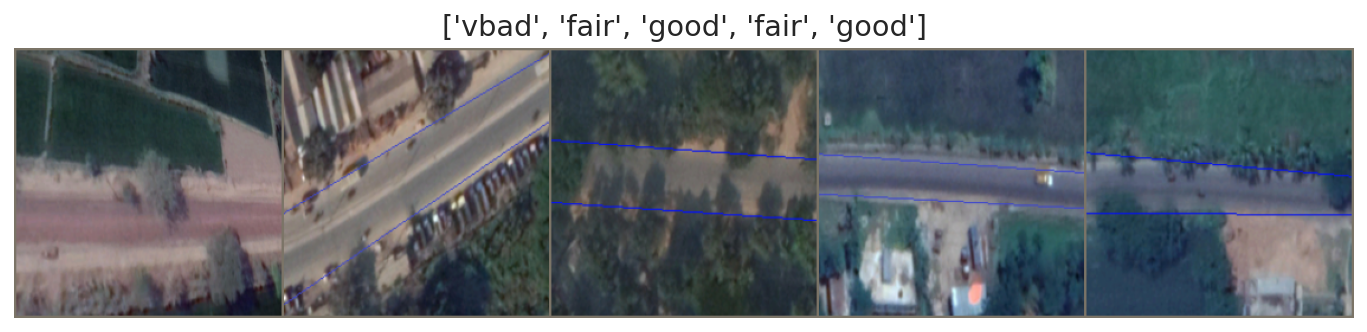

In [45]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [46]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure(figsize=(20,10))

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}\n'  f'true: {class_names[labels[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

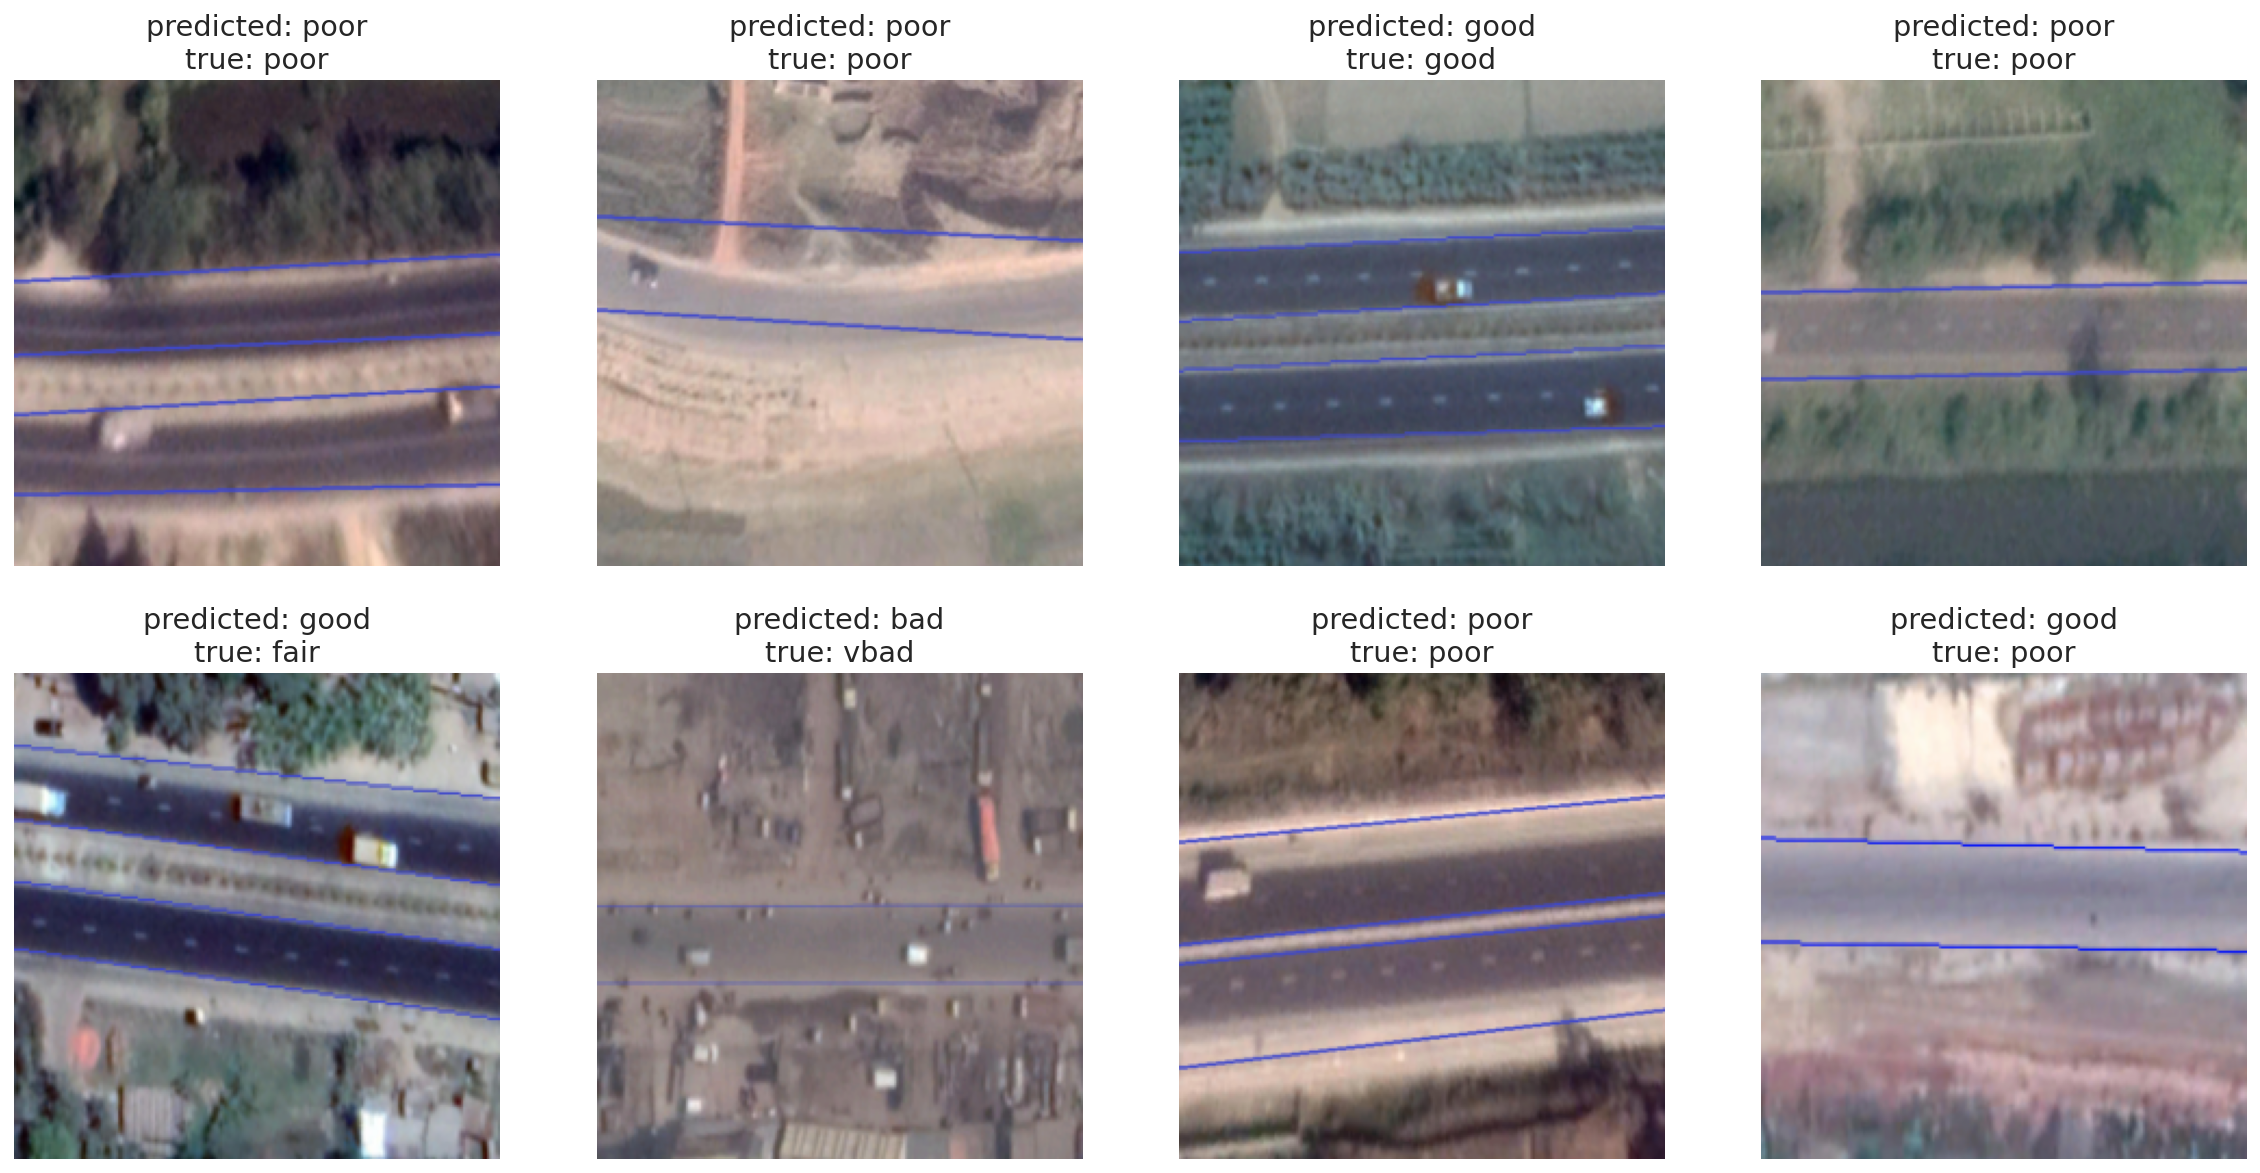

In [47]:
show_predictions(base_model, class_names, n_images=8)

In [48]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [49]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [45]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.83      0.73      0.77       251
        fair       0.71      0.68      0.69       290
        good       0.72      0.77      0.74       295
        poor       0.82      0.84      0.83       263
        vbad       0.75      0.80      0.77       231

    accuracy                           0.76      1330
   macro avg       0.76      0.76      0.76      1330
weighted avg       0.76      0.76      0.76      1330



In [50]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.83      0.84      0.84       251
        fair       0.88      0.69      0.78       290
        good       0.78      0.90      0.84       295
        poor       0.91      0.84      0.88       263
        vbad       0.75      0.87      0.81       231

    accuracy                           0.83      1330
   macro avg       0.83      0.83      0.83      1330
weighted avg       0.83      0.83      0.83      1330



In [51]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

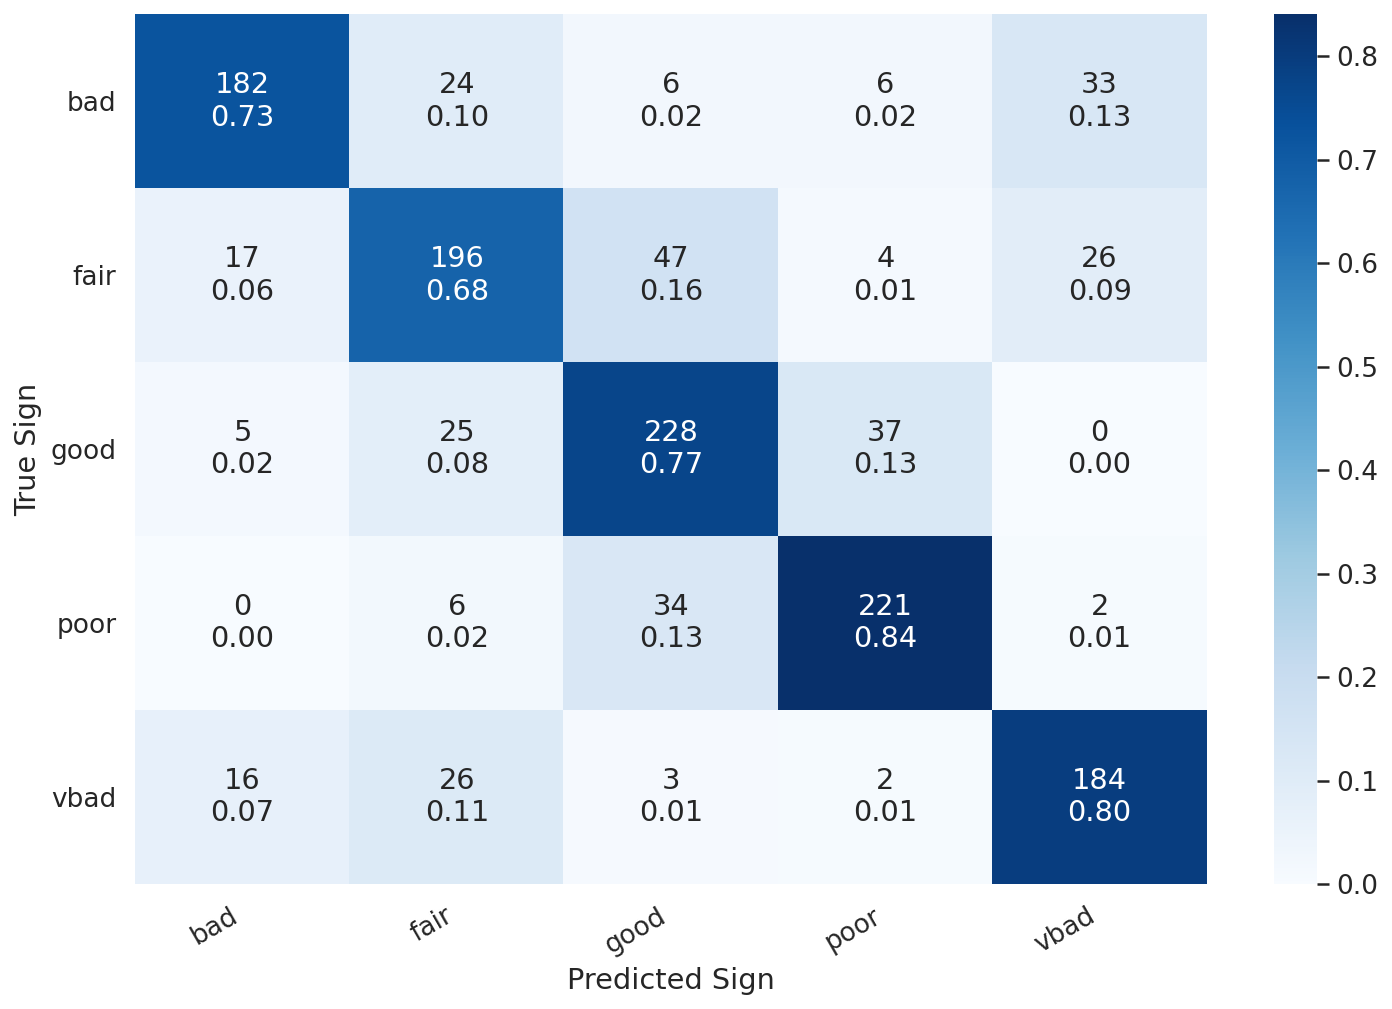

In [47]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

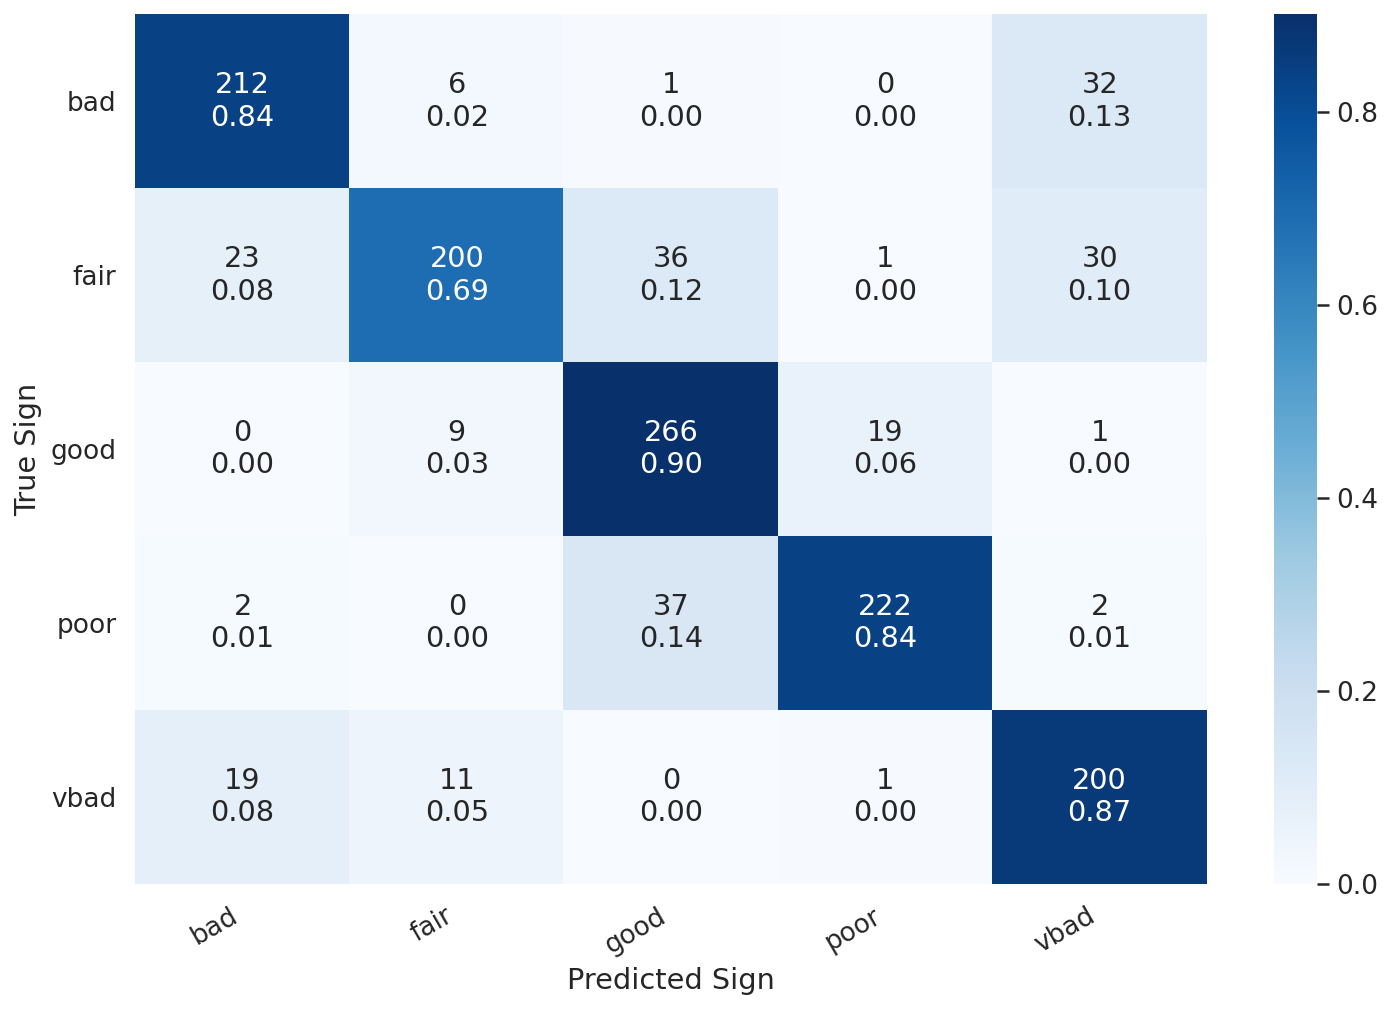

In [52]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

# **Hold out dataset(New Road for testing)**

In [53]:
held_folders = sorted(glob('/content/drive/MyDrive/heldoutV2/*'))
len(held_folders)

5

In [54]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

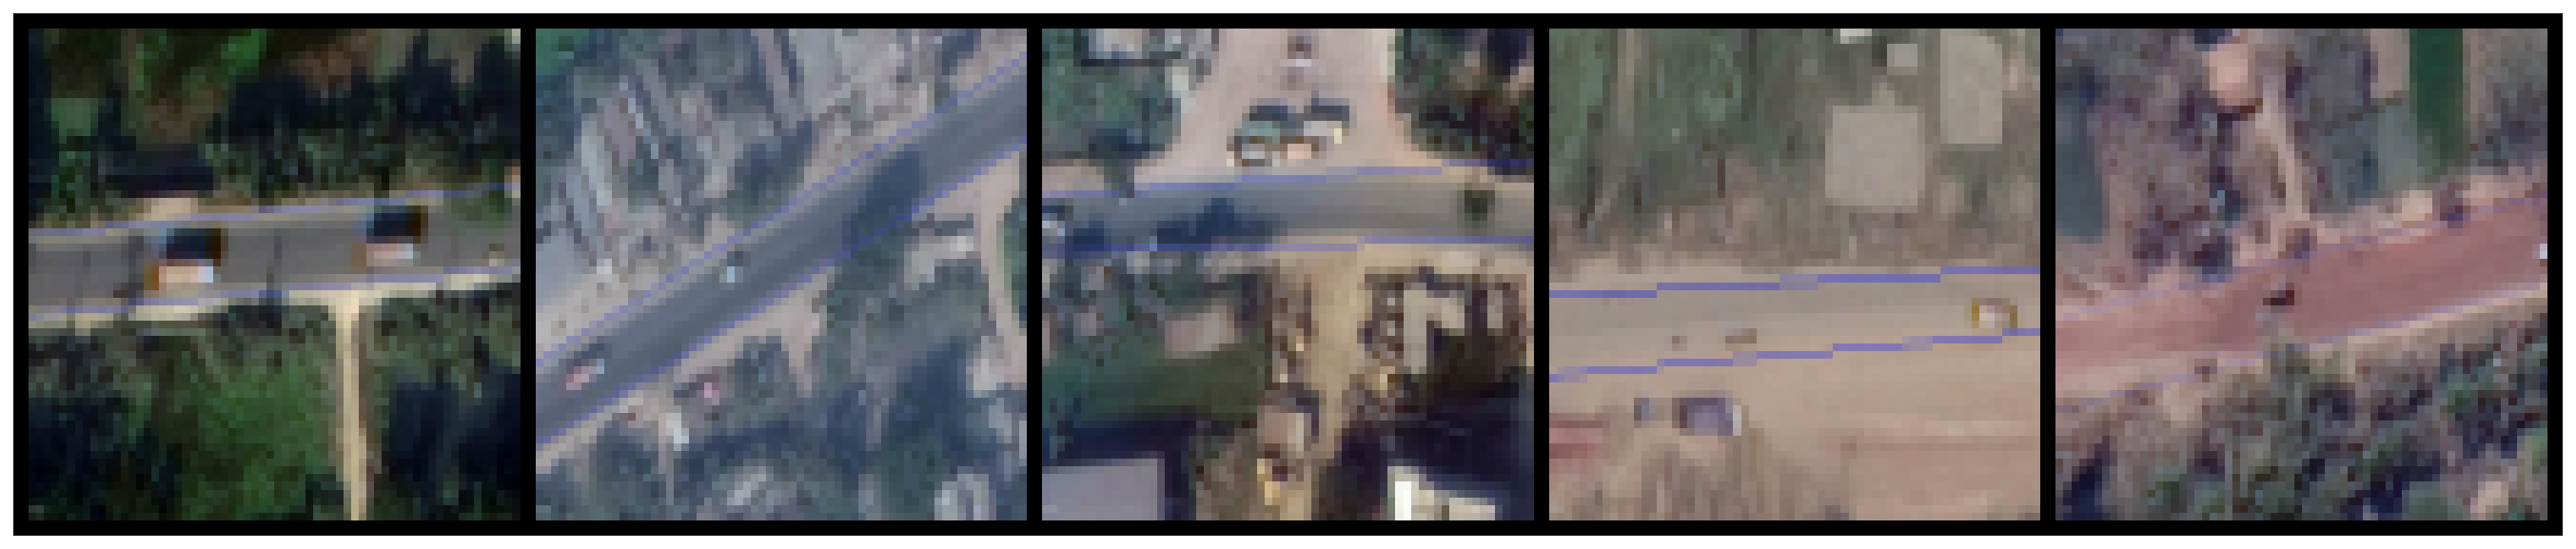

In [55]:
sample_images = [np.random.choice(glob(f'{tf}/*png')) for tf in held_folders]
show_sign_grid(sample_images)

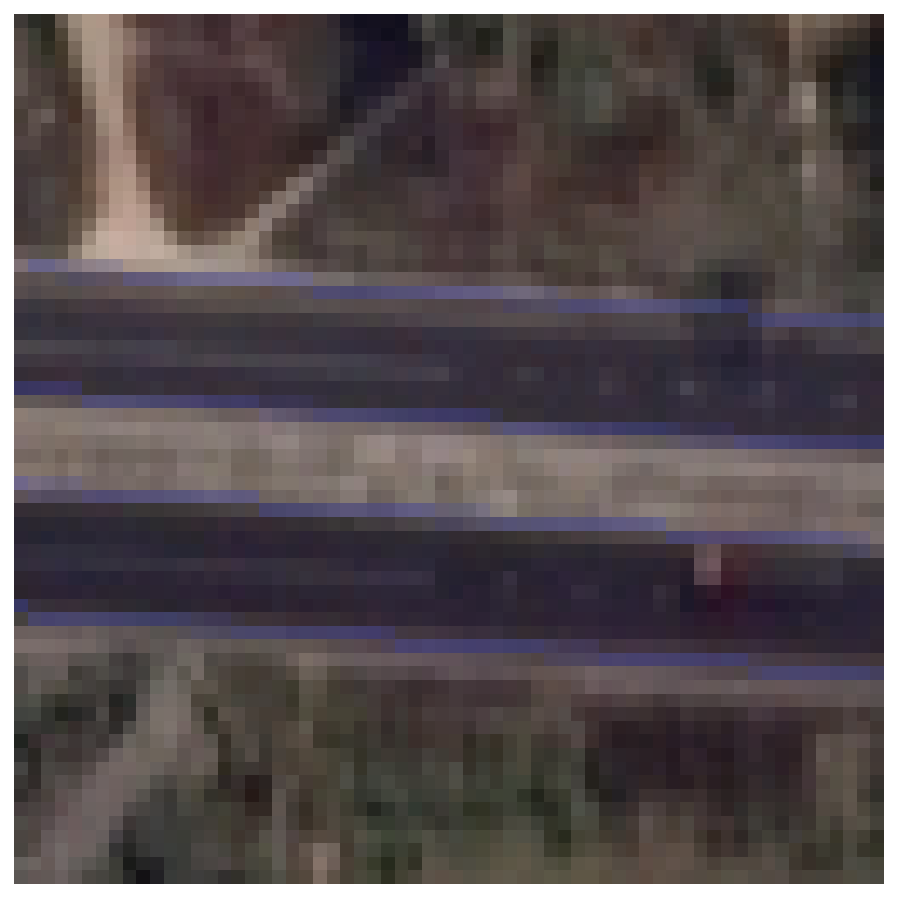

In [56]:
img_path = glob(f'{held_folders[2]}/*png')[20]

show_image(img_path)

In [57]:
class_names = ['bad', 'fair', 'good', 'poor','vbad']

class_indices = [0, 1, 2, 3, 4]

In [58]:
!rm -rf data

DATA_DIR = Path('heldout_data')

DATASETS = ['heldout_test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

In [59]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{held_folders[cls_index]}/*.png'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(1.0*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

bad: 104
fair: 115
good: 113
poor: 91
vbad: 94


In [57]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=80),
  T.CenterCrop(size=64),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [60]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'heldout_test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

In [61]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=10, shuffle=True, num_workers=2) 
  for d in DATASETS
}

In [62]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['heldout_test'].classes

dataset_sizes

{'heldout_test': 517}

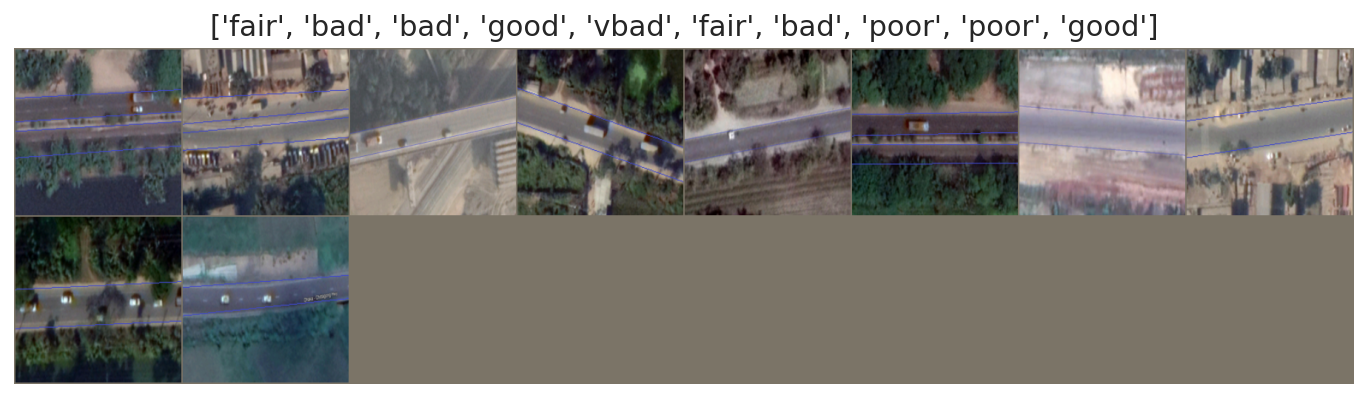

In [63]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['heldout_test']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [64]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [65]:
y_pred, y_test = get_predictions(base_model, data_loaders['heldout_test'])

In [63]:
#64*64
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.62      0.63      0.63       104
        fair       0.35      0.48      0.40       115
        good       0.44      0.36      0.40       113
        poor       0.80      0.49      0.61        91
        vbad       0.57      0.63      0.60        94

    accuracy                           0.51       517
   macro avg       0.56      0.52      0.53       517
weighted avg       0.54      0.51      0.52       517



In [66]:
#224*224
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

         bad       0.74      0.67      0.70       104
        fair       0.35      0.57      0.43       115
        good       0.45      0.26      0.33       113
        poor       0.73      0.44      0.55        91
        vbad       0.56      0.68      0.62        94

    accuracy                           0.52       517
   macro avg       0.57      0.52      0.53       517
weighted avg       0.56      0.52      0.52       517



In [67]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

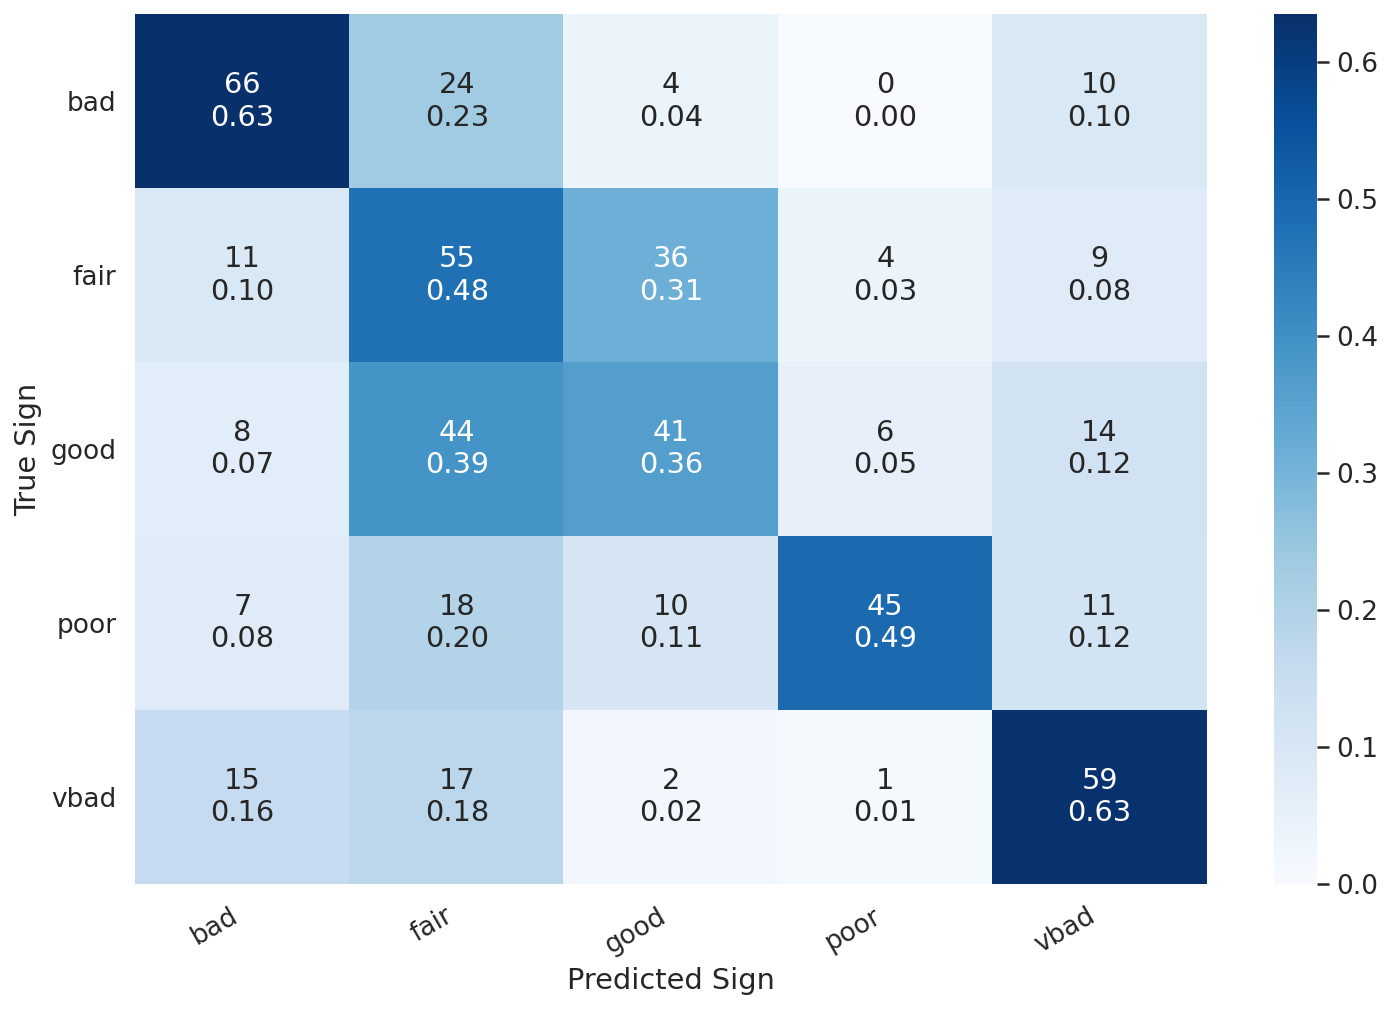

In [65]:
#64*64
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

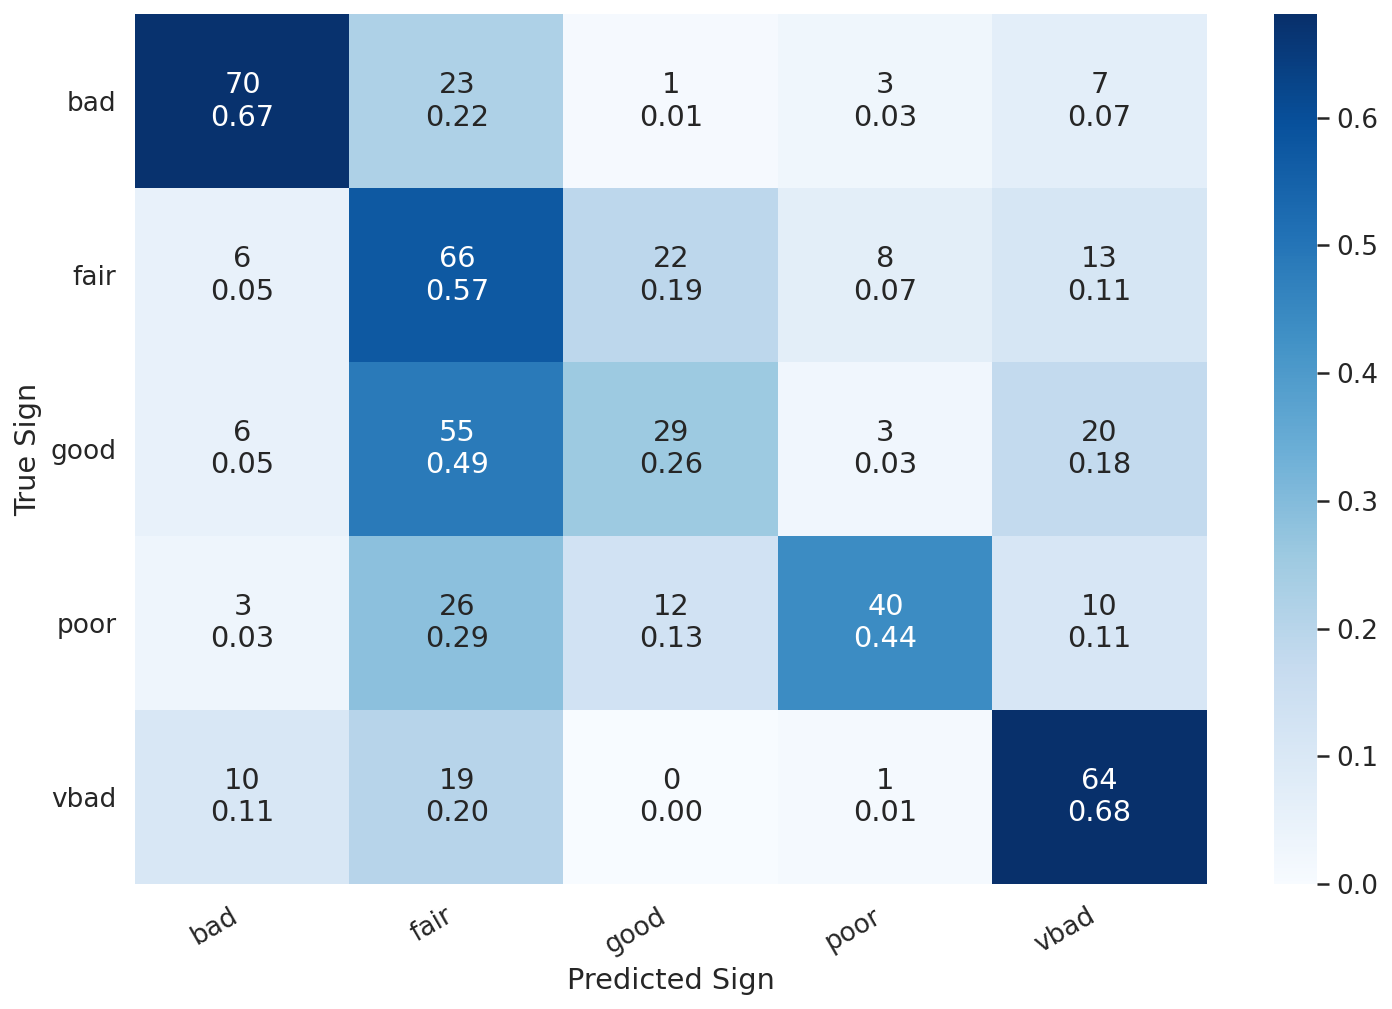

In [68]:
#224*224
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

In [69]:
root_path = '/content/drive/My Drive/'

In [71]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'Vgg1170304.pkl') 

In [76]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Vgg11703064.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


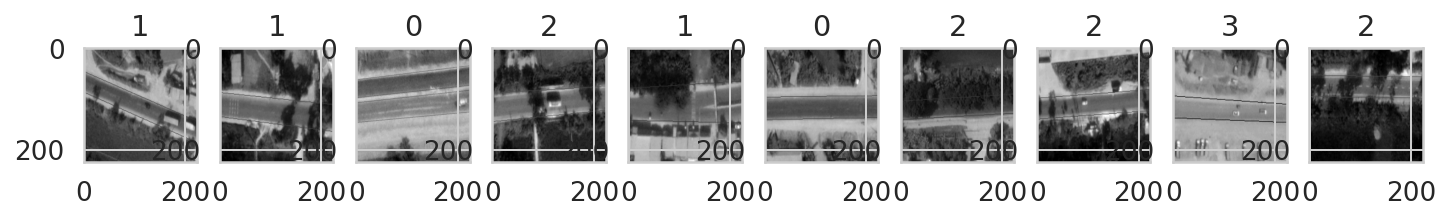

In [78]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(64, 64)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [ ]:
predictions = base_model.forward(images[:10].view(-1, 3,64,64).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

# 224*224

In [ ]:
root_path = '/content/drive/My Drive/'

In [72]:
save_model = True

if save_model is True:
    # Saves only parameters
    # wights & biases
    torch.save(base_model.state_dict(), root_path + 'Vgg117030224.pkl') 

In [73]:
load_model = True

if load_model is True:
    base_model.load_state_dict(torch.load(root_path + 'Vgg117030224.pkl'))
    print('Trained Model Loaded')

Trained Model Loaded


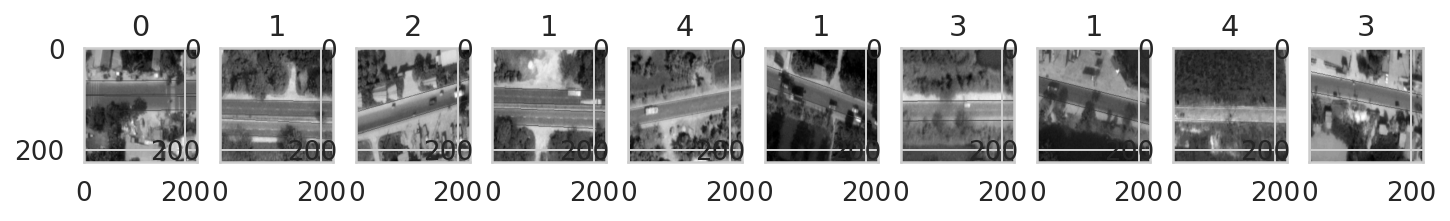

In [74]:
for images, labels in data_loaders['heldout_test']:
    break
    
fig, ax = plt.subplots(1, 10)
for i in range(10):
    show_img = images[i][0].numpy().reshape(224, 224)
    ax[i].imshow(show_img,cmap='gray')
    ax[i].set_title(int(labels[i]))
    
plt.show()

In [75]:
predictions = base_model.forward(images[:10].view(-1, 3,224,224).to(device))
predictions = torch.argmax(predictions, dim=1)
print('Predicted labels', predictions.cpu().numpy())

Predicted labels [3 2 1 2 4 1 3 1 4 1]
